<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/rating/inspect_train_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determine confidence threshold for Image Rating Classification Models 
---
*Last Updated 26 October 2021*   
Choose which trained model and confidence threshold values to use for classifying EOL image ratings. Threshold values should be chosen that maximize coverage and minimize error.

First, choose the best models trained in [rating_train.ipynb](https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/rating/rating_train.ipynb). Then, run this notebook. 

1) Save model predictions and confidence values for 50 images per class (Image rating 1-5) for best models chosen in rating_train.ipynb (Run 20: Inception v3 - trained on 'good' and 'bad' classes; Run 18: Mobilenet SSD v2 - trained on 'good' and 'bad' classes; Run 06: Inception v3 - trained on numerical rating classes 1-5).   
2) Load saved model prediction and confidence files from 1.   
3) Visualize confidence values for true and false predictions per class to determine thresholds for use with image type classifiers (with option to inspect by taxon).

## Installs & Imports
---

In [1]:
# Mount google drive to import/export files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# For working with data
import itertools
import os
import numpy as np
import pandas as pd

# For downloading and displaying images
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# For measuring inference time
import time

# For image classification and training
import tensorflow as tf

# Define functions

# To read in EOL formatted data files
def read_datafile(fpath, sep="\t", header=0, disp_head=True, lineterminator='\n', encoding='latin1'):
    """
    Defaults to tab-separated data files with header in row 0
    """
    try:
        df = pd.read_csv(fpath, sep=sep, header=header, lineterminator=lineterminator, encoding=encoding)
        if disp_head:
          print("Data header: \n", df.head())
    except FileNotFoundError as e:
        raise Exception("File not found: Enter the path to your file in form field and re-run").with_traceback(e.__traceback__)
    
    return df

# List filenames of all images used for training/testing models
def list_train_images(imclasses):
    # Get image class bundle filenames
    all_filenames = ['image_data/' + imclass + '_download_7k.txt' for imclass in imclasses] 
    print('Image class bundles used for training/testing models: \n', all_filenames)
    # Make combined list all image ratings from bundles
    used_images = []
    for fn in all_filenames: 
        df = pd.read_csv(fn, index_col=None, header=1, sep='\n')
        df.columns = ['link']
        used_images.append(df)
    used_images = pd.concat(used_images, axis=0, ignore_index=True)
    print('No. image ratings used for training/testing: {}'.format(len(used_images),
                                                                   used_images.head()))

    return used_images

# Remove all images used for training/testing from EOL bundle
def remove_used_images(df, used_images, dataset):
    print("Total image ratings available for {}: {}".format(dataset, len(df)))
    if 'object_url' in df:
        df.rename(columns={'object_url':'obj_url'}, inplace=True)
    condition = df['obj_url'].isin(used_images['link'])
    df.drop(df[condition].index, inplace = True)
    unused_images = df.copy()
    print("Total un-used image ratings available for {}: {}".format(dataset, len(unused_images)))

    return unused_images

# Make master unused image dataset for ratings and exemplars
def make_master_unused_df(ratings, exemplars):
    # Reformat image ratings to match exemplars
    df1 = unused_ratings[["obj_with_overall_rating", "obj_url", "overall_rating", "ancestry"]].copy()
    df1.rename(columns={"obj_with_overall_rating": "obj_id"}, inplace=True)
    print(df1.head())
    # Reformat image exemplars to match ratings
    df2 = unused_exemplars[["target_id", "obj_url", "ancestry"]].copy()
    df2.rename(columns={"object_url":"obj_url", "target_id": "obj_id"}, inplace=True)
    df2["overall_rating"] = 5
    # Merge ratings and exemplars
    unused_images = pd.concat([df1, df2])
    print("Master un-used image ratings for validation (ratings + exemplars): {}\n{}".format(len(unused_images), unused_images))

    return unused_images

## Build validation dataset (Only run once)
---
Build dataset of image ratings for images not previously seen by models.  
Removes image ratings found in EOL user generated rating and exemplar files that were used in 7k training/testing datasets 

In [3]:
# Find images with ratings that were not used for training or testing models 

# TO DO: Type in the path to your working directory in form field to right
wd = "/content/drive/MyDrive/train/" #@param {type:"string"}

# Set current working directory
cwd = wd + 'pre-processing/'
%cd $cwd

# Get list of images used for 7k training/testing datasets
# TO DO: Make list of image classes used for training
imclasses = ['1', '2', '3', '4', '5'] #@param
used_images = list_train_images(imclasses)

# Remove images already used for training/testing from EOL rating dataset
df = read_datafile("image_data/image_ratings.txt", disp_head=False)
unused_ratings = remove_used_images(df, used_images, "Ratings")
unused_ratings.to_csv('image_data/unused_image_ratings_foreval.txt', sep="\t", index=False, header=True)

# Remove images already used for training/testing from EOL exemplar dataset (used to supplment rating=5)
df = read_datafile("image_data/images_selected_as_exemplar.txt", disp_head=False)
unused_exemplars = remove_used_images(df, used_images, "Exemplars")
unused_exemplars.to_csv('image_data/unused_image_exemplars_foreval.txt', sep="\t", index=False, header=True)

# Make master unused images dataset for ratings and exemplars
unused_images = make_master_unused_df(unused_ratings, unused_exemplars)
unused_images.to_csv('image_data/unused_images_foreval_master.txt', sep="\t", index=False, header=True)

/content/drive/MyDrive/summer20/classification/pre-processing
Image class bundles used for training/testing models: 
 ['image_data/1_download_7k.txt', 'image_data/2_download_7k.txt', 'image_data/3_download_7k.txt', 'image_data/4_download_7k.txt', 'image_data/5_download_7k.txt']
No. image ratings used for training/testing: 34990


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Total image ratings available for Ratings: 199426
Total un-used image ratings available for Ratings: 171338
Total image ratings available for Exemplars: 18963
Total un-used image ratings available for Exemplars: 17459
     obj_id  ...                                           ancestry
0  12522484  ...  {"genus":{"name":"Phacelia","taxon_concept_id"...
1  13231851  ...  {"genus":{"name":"Paragiopagurus","taxon_conce...
2  32656073  ...  {"genus":{"name":"Acer","taxon_concept_id":"37...
3  32596871  ...                                                NaN
4  33629210  ...  {"genus":{"name":"Brachyglottis","taxon_concep...

[5 rows x 4 columns]
Master un-used image ratings for validation (ratings + exemplars): 188797
         obj_id  ...                                           ancestry
0      12522484  ...  {"genus":{"name":"Phacelia","taxon_concept_id"...
1      13231851  ...  {"genus":{"name":"Paragiopagurus","taxon_conce...
2      32656073  ...  {"genus":{"name":"Acer","taxon_concept_i

## Run images through for classification and validating predictions (Run 1x for each trained model)   
---
Selected models from rating_train.ipynb   
* Run 20: Inception v3 (trained on 'good' and 'bad' classes)
* Run 18: Mobilenet SSD v2 (trained on 'good' and 'bad' classes)
* Run 06: Inception v3 (trained on numerical rating classes 1-5)

In [92]:
# Set parameters 

# TO DO: Choose training attempt number to inspect results for
TRAIN_SESS_NUM = "18" #@param ["20", "18", "06"] {allow-input: true}

# Directory to saved models
saved_models_dir = wd + 'saved_models/'

# Set current working directory
cwd = wd + 'inspect_resul/'
%cd $cwd

# Suppress pandas setting with copy warning
pd.options.mode.chained_assignment = None  # default='warn'

# Define functions

# Define start and stop indices in EOL bundle for running inference   
def set_start_stop(df):
    # To test with a tiny subset, use 5 random bundle images
    N = len(df)
    if test_with_tiny_subset:
        start=np.random.choice(a=N, size=1)[0]
        stop=start+5
    # To run for larger set, use 500 random images
    else : 
        start=np.random.choice(a=N, size=1)[0]
        stop=start+500
    print("Running inference on images")
    
    return start, stop

# Load saved model from directory
def load_saved_model(saved_models_dir, TRAIN_SESS_NUM, module_selection):
    # Load trained model from path
    saved_model_path = saved_models_dir + TRAIN_SESS_NUM
    model = tf.keras.models.load_model(saved_model_path)
    # Get name and image size for model type
    handle_base, pixels = module_selection

    return model, pixels, handle_base

# Get info about model based on training attempt number
def get_model_info(TRAIN_SESS_NUM):
    # Session 18
    if int(TRAIN_SESS_NUM) == 18:
        module_selection =("mobilenet_v2_1.0_224", 224)
        dataset_labels = ['bad', 'good'] # Classes aggregated after attempt 7: 1/2 -> bad, 4/5 -> good
    # Session 20
    elif int(TRAIN_SESS_NUM) == 20:
        module_selection = ("inception_v3", 299)
        dataset_labels = ['bad', 'good'] # Classes aggregated after attempt 7: 1/2 -> bad, 4/5 -> good
    # Session 6
    elif int(TRAIN_SESS_NUM) == 6:
        module_selection = ("inception_v3", 299)
        dataset_labels = ['1', '2', '3', '4', '5'] # Before aggregating classes

    return module_selection, dataset_labels

# Set filename for saving classification results
def set_outpath(true_imclass):
    outpath = wd + 'inspect_resul/ratings_' + TRAIN_SESS_NUM + '_' + true_imclass + '.csv'
    print("Saving results to: \n", outpath)

    return outpath

# Load in image from URL
# Modified from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/saved_model.ipynb#scrollTo=JhVecdzJTsKE
def image_from_url(url, fn):
    file = tf.keras.utils.get_file(fn, url) # Filename doesn't matter
    disp_img = tf.keras.preprocessing.image.load_img(file)
    image = tf.keras.preprocessing.image.load_img(file, target_size=[pixels, pixels])
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(
        image[tf.newaxis,...])

    return image, disp_img

# Get info from predictions to display on images
def get_predict_info(predictions, url, i, stop, start):
    # Get info from predictions
    label_num = np.argmax(predictions[0], axis=-1)
    conf = predictions[0][label_num]
    im_class = dataset_labels[label_num]
    # Display progress message after each image
    print("Completed for {}, {} of {} files".format(url, i, format(stop-start, '.0f')))
    
    return label_num, conf, im_class

# Record results for confidence thresholds
# Make placeholder lists to fill for each class
def make_placeholders():
    filenames = []
    confidences = []
    true_imclasses = []
    det_imclasses = []
    ancestries = []

    return filenames, confidences, true_imclasses, det_imclasses, ancestries
    
# Add values for each image to placeholder list
def record_results(fn, conf, true_imclass, det_imclass, ancestry):
    filenames.append(fn)
    confidences.append(conf)
    true_imclasses.append(true_imclass)
    det_imclasses.append(str(det_imclass))
    ancestries.append(ancestry)
    results = [filenames, confidences, true_imclasses, det_imclasses, ancestries]

    return results

# Export results
def export_results(results):
    results = pd.DataFrame(results)
    results = results.transpose()
    results.to_csv(outpath, index=False, header=("filename", "confidence", 
                                                     "true_id", "det_id", "ancestry"))
    print("Classification predictions for image class {}: {}".format(
          true_imclass, results.head()))

/content/drive/MyDrive/summer20/classification/rating/inspect_resul


In [109]:
# Run inference

# Test with tiny subset (5 images)?
# TO DO: If yes, check test_with_tiny_subset box
test_with_tiny_subset = True #@param {type: "boolean"}

# Load saved model
module_selection, dataset_labels = get_model_info(TRAIN_SESS_NUM)
model, pixels, handle_base = load_saved_model(saved_models_dir, TRAIN_SESS_NUM, module_selection)

# Run inference for each image class to compare known versus predicted ratings
true_imclasses = ['1', '2', '3', '4', '5']
for true_imclass in true_imclasses:
    # Set filename for saving classification results
    outpath = set_outpath(true_imclass)

    # Make placeholder lists to record values for each image
    filenames, confidences, true_imclasses, det_imclasses, ancestries = make_placeholders()

    # Load subset of in validation images df for each image class
    df = unused_images.copy()
    df = df[df.overall_rating==int(true_imclass)]

    # Run 500 random EOL bundle images through trained model
    start, stop = set_start_stop(df)
    for i, row in df.iloc[start:stop].iterrows():
        try:
            # Read in image from url
            url = df['obj_url'][i]
            fn = str(i) + '.jpg'
            img, disp_img = image_from_url(url, fn)
            ancestry = df['ancestry'][i]
        
            # Image classification
            start_time = time.time() # Record inference time
            predictions = model.predict(img, batch_size=1)
            label_num, conf, det_imclass = get_predict_info(predictions, url, i, stop, start)
            end_time = time.time()
            print("Inference time: {} sec".format(format(end_time-start_time, '.2f')))

            # Record results in placeholder lists to inspect results in next step
            results = record_results(fn, conf, true_imclass, str(det_imclass), ancestry)

        except:
            pass

    # Combine to df and export results
    export_results(results)

Saving results to: 
 /content/drive/MyDrive/summer20/classification/rating/inspect_resul/ratings_18_1.csv
Running inference on images
237568/228353 [===============================] - 0s 0us/step
Completed for http://upload.wikimedia.org/wikipedia/commons/6/64/D%C3%BCrer-rhino.jpg, 104789 of 5 files
Inference time: 0.52
466944/453989 [==============================] - 0s 1us/step
Completed for http://mczbase.mcz.harvard.edu/specimen_images/herpetology/large/A64370_H_rossalleni_P_d.jpg, 104792 of 5 files
Inference time: 0.05
245760/234777 [===============================] - 0s 1us/step
Completed for http://animaldiversity.ummz.umich.edu/collections/contributors/james_dowlinghealey/caracara/medium.jpg, 104794 of 5 files
Inference time: 0.06
Classification predictions for image class 1:             0        1  ...     3                                                  4
0  104789.jpg  4.31948  ...   bad  {"genus":{"name":"Rhinoceros","taxon_concept_i...
1  104792.jpg  3.45571  ...   bad  

In [110]:
# Combine model outputs for image rating classes 1-5

# Combine prediction files created in codeblock above
true_imclasses = ['1', '2', '3', '4', '5']
base = 'ratings_' + TRAIN_SESS_NUM + '_'
all_filenames = [base + true_imclass + '.csv' for true_imclass in true_imclasses]
all_predictions = pd.concat([pd.read_csv(f, sep=',', header=0, na_filter = False) for f in all_filenames])
print("Model predictions for Training Attempt {}, {}:".format(TRAIN_SESS_NUM, handle_base))
print("No. Images: {}\n{}".format(len(all_predictions), all_predictions[['filename', 'true_id', 'det_id']].head()))

# Aggregate numerical "true_id" classes into 'bad' and 'good'
# TO DO: Enter class names
c0 = "bad" #@param {type:"string"}
c1 = "good" #@param {type:"string"}
imclasses = [c0, c1]

# All predictions of 1 or 2 become 'bad'
all_predictions.true_id[(all_predictions.true_id==1) | (all_predictions.true_id==2)] = c0
all_predictions.det_id[(all_predictions.det_id==1) | (all_predictions.det_id==2)] = c0

# All predictions of 4 or 5 become 'good'
all_predictions.true_id[(all_predictions.true_id==4) | (all_predictions.true_id==5)] = c1
all_predictions.det_id[(all_predictions.det_id==4) | (all_predictions.det_id==5)] = c1

# Remove all predictions of 3
all_predictions = all_predictions[all_predictions.det_id!=3]
all_predictions = all_predictions[all_predictions.true_id!=3]

print("Numeric image ratings successfully aggregated into {} (1-2) and {} (4-5):\n{}".format(c0, c1, all_predictions[['filename', 'true_id', 'det_id']].head()))

Model predictions for Training Attempt 18, mobilenet_v2_1.0_224:
No. Images: 20
     filename  true_id det_id
0  104789.jpg        1    bad
1  104792.jpg        1    bad
2  104794.jpg        1   good
0   78959.jpg        2    bad
1   78963.jpg        2    bad
Numeric image ratings successfully aggregated into bad (1-2) and good (4-5):
     filename true_id det_id
0  104789.jpg     bad    bad
1  104792.jpg     bad    bad
2  104794.jpg     bad   good
0   78959.jpg     bad    bad
1   78963.jpg     bad    bad


## Plot prediction error and confidence for each class (Run 1x for each trained model)
---   
Use these histograms to find a confidence threshold value to optimize dataset coverage and accuracy

In [157]:
# Define functions

# Valide predictions by image class (and optionally, by: taxon)
def validate_predictions(df, inspect_by_taxon):
    # If inspecting for taxon-specific images only
    taxon = None
    if inspect_by_taxon:
        # TO DO: Type in the taxon you'd like to inspect results for using form field to right
        taxon = "" #@param {type:"string"}
        df = df.loc[df.ancestry.str.contains(taxon, case=False, na=False)]
        print("Inspecting results for {}:\n{}".format(taxon, df.head()))
    
    # Validate predictions
    # Check where true ratings and model-determined classes match
    df['det'] = (df['true_id'] == df['det_id'])
    tru = df.loc[df.det, :] # True ID
    fal = df.loc[~df.det, :] # False ID
    
    # Inspect by image class and confidence values
    # Check how many true/false predictions are at each confidence value
    # Class 0 - 'Bad'
    c0t = tru.loc[tru['true_id'] == c0, :] # True dets
    c0f = fal.loc[fal['true_id'] == c0, :] # False dets
    # Class 1 - 'Good'
    c1t = tru.loc[tru['true_id'] == c1, :] # True dets
    c1f = fal.loc[fal['true_id'] == c1, :] # False dets

    return tru, fal, c0t, c0f, c1t, c1f, taxon

# Plot results by image class
def plot_predict_x_conf(tru, fal, c0t, c0f, c1t, c1f, imclasses=imclasses, thresh=thresh):
    # Plot parameters to make 1 subplot per image class
    kwargs = dict(alpha=0.5, bins=15)
    fig, axes = plt.subplots(len(imclasses), figsize=(10, 10), constrained_layout=True)
    fig.suptitle('Prediction Confidence by Class\n Overall Accuracy: {}'.format(
                  format((len(tru)/(len(tru)+len(fal))),'.2f')))
    
    # Make subplots

    # Class 0 - 'Bad'
    c0 = df.iloc[:, :N] # Pull N items for c0
    # True predictions
    axes[0].hist(c0t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[0].hist(c0f['confidence'], color='r', label='False Det', **kwargs)
    axes[0].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[0], 
                      len(c0t+c0f), format((len(c0t)/(len(c0t)+len(c0f))),'.2f')))
    axes[0].legend();

    # Class 1 - 'Good'
    c1 = df.iloc[:, N:2*N] # Pull N items for c1
    # True predictions
    axes[1].hist(c1t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[1].hist(c1f['confidence'], color='r', label='False Det', **kwargs)
    axes[1].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[1], 
                      len(c1t+c1f), format((len(c1t)/(len(c1t)+len(c1f))),'.2f')))
    axes[1].legend();

    # Add Y-axis labels
    for ax in fig.get_axes():
        ax.set(ylabel='Freq (# imgs)')
        if thresh:
            ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)

    return fig

# To save the figure
def save_figure(fig, TRAIN_SESS_NUM=TRAIN_SESS_NUM, taxon=taxon, handle_base=handle_base):
    # Make filename
    if taxon: # If for a specific taxon
        if 'plant' in taxon:
            handle_base = handle_base + '_plantae'
        elif 'anim' in taxon:
            handle_base = handle_base + '_animalia'

    figname = TRAIN_SESS_NUM + '_' + handle_base + '.png'
    fig.savefig(figname)
    print("Histograms saved to ", figname)

    return figname

Histograms saved to  18_mobilenet_v2_1.0_224.png


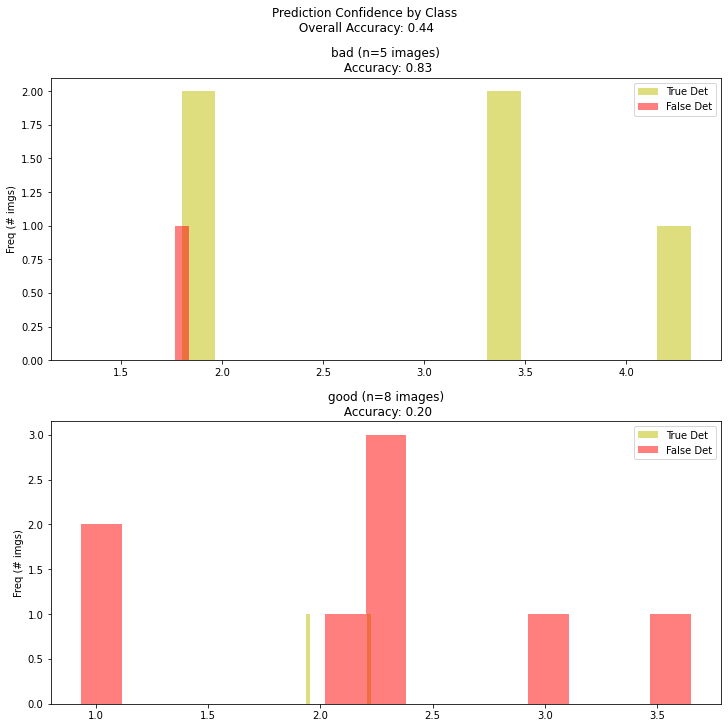

In [158]:
# Load combined prediction results from above
df = all_predictions.copy()

# Optional: Inspect predictions for taxon-specific images only?
# TO DO: If "yes," check box
inspect_by_taxon = False #@param {type:"boolean"}

# Optional: Draw threshold value to help choose optimal balance b/w maximizing useful data and minimizing error
# TO DO: Set threshold value
thresh = 0 #@param {type:"number"}

# Valide predictions by image class (and optionally, by: taxon)
tru, fal, c0t, c0f, c1t, c1f, taxon = validate_predictions(df, inspect_by_taxon)

# Plot results by image class
fig = plot_predict_x_conf(tru, fal, c0t, c0f, c1t, c1f)

# Export histograms
figname = save_figure(fig)